# "End to End Deep Learning Project with fastai, FastAPI, Docker and Heroku"
> "A simple and detailed tutorial on how to go about creating your own state-of-the-art image classifier and deploy it using fastai, FastAPI, Docker and Heroku"

- toc: true
- author: Sayantan Karmakar
- badges: true
- hide_binder_badge: true
- comments: true
- categories: [fastai, FastAPI, Docker, Heroku, CNN]
- show_tags: true

In [1]:
#hide
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 7.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# Acknowledgment

Before starting on with this tutorial, I would like to mention a few names and resources without which this wouldn't have been possible.

Firstly, I would like to thank [Jeremy Howard](https://twitter.com/jeremyphoward), [Sylvain Gugger](https://twitter.com/GuggerSylvain) and [Rachel Thomas](https://twitter.com/math_rachel) for creating fastai, along with its [course](https://course.fast.ai) and their new book, [Deep Learning for Coders with fastai and PyTorch](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/) which makes Deep Learning easier and accessible than ever. Then I would like to thank [Hamel Husain](https://twitter.com/HamelHusain) for creating fastpages, with which this entire blog post was made. It's such a great tool, and I would encourage everyone thinking of starting a blog to check it out!

And finally, I would like to thank the entire fastai community, for helping me out with my silly doubts on the forums and discord channel, special mention to [Zach Mueller](https://twitter.com/TheZachMueller)!

# Introduction

In this tutorial, we'll look at how easy and fast training a **state-of-the-art** Convolutional Neural Network on the **Oxford-IIIT Pet Dataset** dataset, conveniently provided by fastai, to classify 37 different categories of pet breeds. Then we'll use this model to create an API which when provided with an image input, will send back a response to the client. We will then deploy this API using Docker and Heroku to create your very own fully functioning web app.

Since this tutorial is going to be more focused on getting a simple app deployed, rather than how to create the best model possible, a list of prerequisites would be - 

* Understanding of Neural Networks, and its underlying concepts
* Basic HTML and Javascript knowledge

If you're unfamiliar with Deep Learning, I highly recommend you to take the [fastai course](https://course.fast.ai) and I hope this tutorial gets you excited enough about Deep Learning with fastai!

All the code for this project is available in this [Github repo](https://github.com/sayantank/pets-fastapi)!

# Getting Started

## Python packages

To get started, we need to install [PyTorch](https://pytorch.org/get-started/locally/), [fastai](https://docs.fast.ai) and [FastAPI](https://fastapi.tiangolo.com/) on our system. Ideally, I would recommend everyone to use Anaconda/Miniconda to manage your Python packages and environments.

Assuming you have Anaconda/Miniconda installed, the following lines of code would install the required packages for this tutorial - 

```
$ conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

$ pip install --upgrade fastai

$ pip install fastapi[all]
```

## Docker and Heroku

Installing is a pretty straightforward process that you can follow in their [documentation](https://docs.docker.com/get-docker/), and if you're using Windows or Mac, I highly recommend installing the **Docker Desktop**. Once you're done installing it, you'll also have to sign up, which they ask you during the installation process.

You'll also need to install the **Heroku CLI**, which again, you can follow their [documentation](https://devcenter.heroku.com/articles/heroku-cli). Make sure you sign up on Heroku and have an account ready, as you'll be needing it later in the tutorial.

## Development environment

If you've followed the fastai course, you would know that the best way to write fastai code is in a IPython notebook environment, as fastai provides many additional features which help your training process be much easier and insightful. Hence I would recommend everyone to either install [Jupyterlab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) on their systems, or check out [Google Colab](https://colab.research.google.com/), which provides you with a Notebook environment in your browser, along with **free GPU support!!**.

For the rest of the tutorial, excluding the fastai code, I would recommend any text editor of your choice, but **VSCode** would be preferred as it provides with many features like type-checking for FastAPI.

> Tip: If your system doesn't have GPU support, I highly recommend using **Google Colab** as it will make training your model much faster!

# Preparing our Model

## Importing libraries

Believe it or not, but we only need a **single** import statement thing to train our entire model.

In [2]:
from fastai.vision.all import *

Now some of you might say it is a _bad practice_ to `import *` in a Python project, but that is the beauty of fastai, which keeps in mind all the issues that would come in doing so, and is written in such a way that it is ***recommended*** to import it like this!

## Getting our data

To make things easy, I chose on purpose to use **[The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)** dataset, which is provided by fastai out-of-the-box. We just have to download it, and untar the downloaded file. This can be easily done with the following code.

In [3]:
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

> Note: Depending on your system, this `path` object will be of either `class pathlib.PosixPath` or `class pathlib.WindowsPath`. This is a built-in feature of Python, which I would say is one of the most useful features I've come across while learning fastai and would highly recommend you to check out the **`pathlib`** library. 

Before we start creating our datasets and dataloaders, we should always check how our data is organized to get an idea of how we're supposed to label and divide our data.

In [5]:

path.ls()


(#2) [Path('annotations'),Path('images')]

In [6]:

(path/'images').ls()


(#7393) [Path('images/shiba_inu_124.jpg'),Path('images/Bengal_57.jpg'),Path('images/german_shorthaired_187.jpg'),Path('images/english_setter_197.jpg'),Path('images/Maine_Coon_126.jpg'),Path('images/american_pit_bull_terrier_146.jpg'),Path('images/miniature_pinscher_188.jpg'),Path('images/Bombay_132.jpg'),Path('images/Abyssinian_44.jpg'),Path('images/leonberger_71.jpg')...]

As we can see from the above blocks of code, our data is first divided into `annotations` and `images` directories. We'll only be using the `images` directory for this tutorial. In the `images` directory, the files are named in a fixed pattern containing the pet breed's name.

Hence, we see that the labels of the images can be extracted from their **file names**. Later in this section, we'll see how easy it is to label your images using fastai!

## Creating our DataBlock

Now that we had a look at our data, and know how to go about labelling them. We now have to create, what we call `Dataset` and `Dataloader` in PyTorch, which are the two main classes for representing and accessing training or validation data.

* `Dataset`: A collection that returns a tuple of your independent and dependent variable for a single item.
* `DataLoader`: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables.

Since a `DataLoader` builds on top of a `Dataset` and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after that’s working.

For example,

In [7]:

x = list(np.arange(0,26))
y = [chr(ord('a') + i)  for i in x]
dset = list(zip(x,y))

for i in range(3):
    print(dset[i])


(0, 'a')
(1, 'b')
(2, 'c')


Hence, the `dset` object in the code above, is a valid `Dataset` in PyTorch as we can index it, and it returns a tuple of the independent and dependent variable, which in this case is integers from **0 to 26** and letters **a to z** respectively.

Now if you wish to create a `DataLoader` for this `Dataset`, you can use the following function provided by PyTorch:

In [8]:

dloader = torch.utils.data.DataLoader(dset, batch_size=4,
                                      shuffle=True, drop_last=True)
for i in dloader:
    print(i)


[tensor([ 2, 23,  6,  7]), ('c', 'x', 'g', 'h')]
[tensor([ 4, 12, 21,  0]), ('e', 'm', 'v', 'a')]
[tensor([ 8,  1, 22, 11]), ('i', 'b', 'w', 'l')]
[tensor([25, 19, 16, 14]), ('z', 't', 'q', 'o')]
[tensor([13,  5, 20, 17]), ('n', 'f', 'u', 'r')]
[tensor([15,  3, 10,  9]), ('p', 'd', 'k', 'j')]


As you can see, iterating over the `DataLoader`, it returns a list with a tensor representing a batch of independent variables, and along with it, a tuple of its corresponding dependent variables.

The parameters of the above function are pretty self-explanatory except maybe `drop_last`, which allows you to drop the last batch of data if it is not of the given `batch_size` as in some cases it is important to have all your batches of similar sizes.


On top of these, fastai provides two classes for bringing your training and validation sets together:

* `Datasets`: An object that contains a training Dataset and a validation Dataset
* `DataLoaders`: An object that contains a training DataLoader and a validation DataLoader

Now that we understand how `Dataset` and `DataLoaders` work, thanks to fastai again, we can leave the hassle of splitting our data into training and validation data, and then making the necessary `Datasets` and `DataLoaders` to the amazing high-level data-block API.

For our tutorial, to create the required the `DataBlock`, the following code should do all the required steps, which we'll understand as we move on!

In [14]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

The parameters required to define the DataBlock object are as follows:

* **`blocks`**: This represents the type of data we wish to represent, hence for this tutorial, our independent variable is an image, and dependent variable will be an integer, representing a category. Hence our problem in hand is a multi-class Classificiation problem.

* **`get_items`**: This is a function which is run when given a path usually, returns the list of items. In this case, `get_image_files` is a function which if given a path, recursively finds out all the image files in the directory, and returns their paths as a list.

* **`splitter`**: This is a function which when given the list of all items, returns two lists, representing the training set and validation set. In this case, we are _randomly splitting_ the images, keeping 20% for validation set.

* **`get_y`**: This is function, which is mapped to all the items in the list mentioned above, to extract the dependent variable from it, which we call as **y** usually. `RegexLabeller` is a function that takes in a regex expression and applies it on the file name to get the label.

> Note: Regular expressions (Regex) is a sequence of characters that define a search pattern.

* **`item_tfms`**: In PyTorch, we have functions called `Transforms`, which when given an image, performs certain operations on it. Here, `Resize` is a transform, which as the name suggest, resizes the image to shape `(128,128)`.

* **`batch_tfms`**: This is meant for transforms to perform **Data Augmentation**. These transformations are applied on the batch as a whole, on the GPU, so that the process is fast. Whereas `item_tfms` is applied on the CPU usually, and to each and every item in the data.

> Note: I would love to go on about Data Augmentation and Regex in this tutorial, but since we have so much to cover, I believe it is out of scope for this tutorial but I would again highly recommend reading about it or follow the fastai course.

Now that we have our `DataBlock` ready, to get our `DataLoaders`, we simply run the following code:

In [15]:
dls = pets.dataloaders(path/'images', bs=128)

In [12]:
#hide
# This is because Windows doesnt support multiprocessing, and hence have to set num_workers=0
# dls = dblock.dataloaders(path, bs=64, num_workers=0)

Now to access the training set or validation set, we can run `dls.train` and `dls.valid` respectively.

It is good practice usually to have a look at our batch of data before moving on, to see if everything works. We can do this very easily with the following piece of code: 


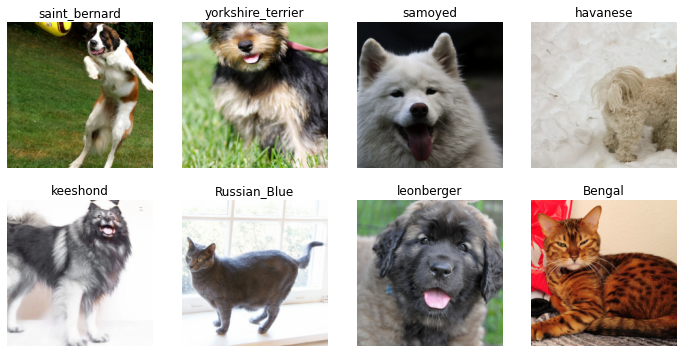

In [16]:
dls.train.show_batch(max_n=8, nrows=2)

Yup, that's it! That's all you have to do to have a look at your batch of data.

We can see that our images look slightly distorted, and this is what we call as **Data Augmentation**, which transforms your images to make it harder for the model to identify, but in practice, makes your model more robust to a variety of inputs. It also obviously solves the problem of lack of training data as now we can create multiple training images from what was initially a single given traning example.

> Tip: If you want to know more about a certain function or object, you can run the code `doc(DataBlock)` for example, to get the documentation on your notebook environment. To have a look at the source code, you can run `DataBlock??` in a cell.

## Training our model

Now that we have our `DataLoaders` ready, we're finally ready to code up our model. But first, we need to decide which model we want to use.

Back in the day, for any type of classification problem, we would look into models like **Logistic Regression**, **Random Forests**, **Multi-layer Perceptrons**, etc. These models would perform great on tabular data, but in this case we're dealing with image data. To use these models with image data, we had to flatten the image pixels into a single vector, which represented the whole image, and was put into these models.

The issue with this is that, even though models like **Multi-layer Perceptrons** have given great results in the past, our input is still linear, and hence the model fails to learn certain features of the image which is lost by flattening the pixel values.

Then in the 1990's, came the first modern use of Convolutional Neural Networks, abbreviated as CNNs, by Yann LeCun et al. in their paper, [“Gradient-Based Learning Applied to Document Recognition”](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) where they used the famous MNIST dataset!

Now, going into understanding CNNs is a whole another blog post in itself and there are so many of them out there on the Internet. Hence, I wont be covering this topic in this tutorial, but here's a [blog post](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/#:~:text=Convolutional%20Neural%20Networks%20(ConvNets%20or,robots%20and%20self%20driving%20cars.) I love, explaining how CNNs work in very detail!

But to give you a high-level idea of CNNs, they basically run filters, which have certain weights associated with them, over an image to determine the various features of the image.

In this tutorial, we'll be using a CNN called **[Resnets](https://arxiv.org/abs/1512.03385)**, which comes pretrained on the [ImageNet dataset](http://www.image-net.org/). By **pretrained**, what I mean is that, this model was trained on the mentioned ImageNet dataset, and then the weights of that model were saved, and now used by Deep Learning lovers all around the world!

> Note: This method of using a pretrained model is called **Transfer Learning**, and I would recommend reading about it once you have a good understanding of CNNs.

Fastai makes transfer learning with well-known models like Resnets, super easy with their `cnn_learner` function, which returns a Learner object. To know more about this, feel free to refer the [docs](https://docs.fast.ai). Basically, a Learner object contains the model, along with features such as plotting losses, printing accuracies as we train, etc. So now, we'll define our `cnn_learner`.

In [24]:
learn = cnn_learner(dls, resnet18, pretrained=True, metrics=accuracy)

Guess what? You have a state-of-the-art model ready to train on your data, in just a single line of code!

> Tip: To have a look at how the model is defined, try running `learn.model` in a code cell.

Now if you're familiar with Backpropagation and Gradient Descent, you might know what a **Learning Rate** is. It is basically a ***hyper-parameter*** that lets you decide how fast your model will learn. But you need to be careful deciding its value, as a value too high or too low, will lead to your model failing to learn properly.

To help you decide a good learning rate, the `Learner` object comes with this function, `Learner.lr_find()` which basically runs the training process, which inclues Backpropagation, Gradient Descent, etc, but with the learning rate increasing as it trains. This Learning Rate finder method was introduced by Leslie Smith, in her paper, [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf).

So let's go ahead and find a good learning rate to train our model!

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.004365158267319202)

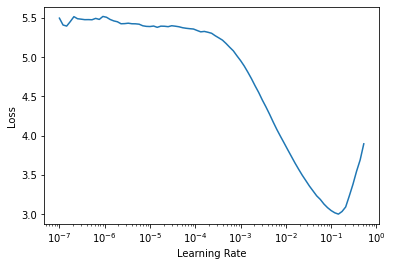

In [18]:
learn.lr_find()

As we see here, a graph of **Loss** against **Learning Rate** is plotted. Usually it is suggested to use a learning rate where the curve is **steepest** since that's where the model seems to be learning the fastest. One would say why not use the learning rate where loss is **minimum**, but if you look at the curve, the curve becomes increasing right after its minimum point, and hence the once you start training, the model will start getting worse within a few epochs.

Some of you might not be familiar with the term **Loss** here. Loss is a value to evaluate how well your model is training. It is usually a function that takes in **true values** of your data, and the **predicted values** by your model as input and then outputs a single value representing how close your model is to predicting te true values. Lesser the loss, better your model is doing.

Fastai has the ability to figure out which loss function is right for your problem, which you can also specify with the `loss_func` parameter to the `cnn_learner` explicitly. Since the problem we're dealing with is a Multiclass Classification, a Cross Entropy loss would be right for us.

> Note: Going into how Cross Entropy works is out of scope for this tutorial, but it basically looks at predicted probabilities for each class of output and checks how far they are from the true values.

In [19]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Now we can go ahead and train our model! We'll be using a learning rate of `5e-3`

In [25]:
learn.fine_tune(5, lr=4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.266739,0.391897,0.874831,01:00


epoch,train_loss,valid_loss,accuracy,time
0,0.594760,0.311008,0.897158,01:03
1,0.464225,0.309391,0.905277,01:02
2,0.360100,0.263009,0.910014,01:03
3,0.274170,0.239679,0.921516,01:02
4,0.209300,0.237176,0.922869,01:02


With that, we just trained a Resnet on our training data and got an accuracy of **92%** in just around **5 mins!** Believe it or not, but this was actually considered to be state-of-the-art until only a few years back.

One thing I would like to mention is the function `fine_tune` that we ran for this model. Since we're using a pretrained model, how Transfer Learning works is that, apart from the final layer of the model, which allows us to classify, the rest of the model is initially **freezed**. Frozen layers mean they are not trained and hence their weights are not updated. 

Hence, how `fine_tune` works is that, it first runs one epoch with only the final layer **not** frozen, and then runs the number of epochs specified by you, with the whole model **not** frozen.

Now all that's left to do is to save our model, or rather ***export*** our model, which we can do with the following line of code:

In [26]:
learn.export(fname='pets_resnet18.pkl')

With that, we just saw how we go about loading our data, creating `DataBlocks`, `DataLoaders` and `Datasets`, loading our model, pretraining it, and then finally exporting it! 

To learn more about this whole process, do check out the [fastai course](https://course.fast.ai)!

Now we can move on to creating our API with FastAPI!

# Making our API

Before we get started with out API, I would like to tell the readers that this is a very simple application using FastAPI, and there are **many more** cool features to it which you can check out in their [docs](https://fastapi.tiangolo.com/)

> Note: All code following this point, should be done in a text editor, and not a notebook.

## File structure

First we create a main directory, which we'll call `pets-fastapi`. Hence your directory should look something like:

```
- pets-fastapi
    - static
        - styles.css
        - client.js
    - templates
        - index.html
    - main.py
    - pets_resnet18.pkl
```

We'll be adding more files to it whenever required, but for now this will do the job.

## Starter code

### `main.py`

In [ ]:
#collapse
# Importing Libraries
import uvicorn

from fastapi import FastAPI, Request, File, Body
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
from fastapi.middleware.cors import CORSMiddleware

from fastai.vision.all import *

import os
import pathlib
import asyncio
import numpy as np
from PIL import Image
from io import BytesIO

# Initialising app and templating engine
app = FastAPI()
templates = Jinja2Templates(directory="templates")

# Adding static files to serve
app.mount("/static", StaticFiles(directory="static"), name="static")

# Declaring base path
try:
    path = Path(__file__).parent
except:
    # For working on Windows systems
    path = Path(r'C:\\Users\\sayank\\workspace\\pets-fastapi\\')

model_name = 'pets_resnet18.pkl'

# Configuring CORS
origins = [
    "*"
]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Defining root route
@app.get("/", response_class=HTMLResponse)
async def read_item(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

### `templates/index.html`

In [ ]:
#collapse
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link href="../static/styles.css" rel="stylesheet">
    <title>PETS FastAPI</title>
</head>
<body>
    <h1>Upload an image of a pet:</h1>
    <form id='pets-form'>
        <input type="file" id="file-input" />
        <input type="submit"/>
    </form>
    <h2 id="pred"></h2>
    <script src="../static/client.js"></script>
</body>
</html>

For the `main.py` file, the only part I believe which falls into the scope of this tutorial is where we define the root route. Every other part is covered in the [FastAPI docs](https://fastapi.tiangolo.com/).

Firstly, `@app.get("/", response_class=HTMLResponse)` is a **decorator**. A decorator takes the function below it and does something with it. In this case, it tells FastAPI that the function right below is in charge of handling requests that go to:

* the path `/`
* using a `GET` operation

Similarly, you can write decorators for other HTTP methods such as `POST`, `PUT`, `DELETE`, etc.

> Tip: To run your app locally now to test if everything works fine, go ahead and run the following command in your terminal: `$ uvicorn main:app --host 127.0.0.1 --port 8000 --reload`

The `response_class` parameter tells the function that it has to return an HTML file, which in this case is sent using `templates.TemplateResponse("index.html", {"request": request})`

> Note: It is necessary to pass the `request` parameter to the function, and then return it with the `TemplateResponse`.

For the `index.html` file, make sure you link the `styles.css` and `client.js` file. In the Javascript file, we'll go on to submitting a `POST` request to our API, and feel free to add styling of your choice in `styles.css`. Apart from that, we define a form which takes input a file, and a submit button as usual. We also have a `h2` to output our predictions, which we'll set the value for from `client.js`.

## Loading our model

### `main.py`

In [ ]:
#collapse
. . .
. . .
. . .
def load_posix_learner(path):
    save = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    learn = load_learner(path)
    
    pathlib.PosixPath = save
    return learn

async def setup_learner():
    try:
        try:
            learn = load_learner(path/model_name)
        except:
            learn = load_posix_learner(path/model_name)
        learn.dls.device = 'cpu'
        print("Loaded model")
        return learn
    except RuntimeError as e:
        if len(e.args) > 0 and 'CPU-only machine' in e.args[0]:
            print(e)
            message = "\n\nThis model was trained with an old version of fastai and will not work in a CPU environment.\n\nPlease update the fastai library in your training environment and export your model again.\n\nSee instructions for 'Returning to work' at https://course.fast.ai."
            raise RuntimeError(message)
        else:
            raise

learn = None

@app.on_event("startup")
async def startup_event():
    global learn
    tasks = [asyncio.ensure_future(setup_learner())]  # assign some task
    learn = (await asyncio.gather(*tasks))[0]  # get tasks

I'll explain the three functions defined above separately.

**`def load_posix_learner(path)`**

This function is necessary **only** if you're working on a Windows system because the fastai function, `load_learner` uses takes input a `PosixPath` which is not functional in Windows system and hence this is a workaround I found in the amazing fastai forums!

**`def setup_learner()`**

In this function, we implement a nested `try-catch` block, where in the outer block, we try to set our model and its dataloaders to `cpu` instead of `cuda`, since we'll only be using it for inference.

The inner `try-catch` is simply to handle cases of working in a Windows system.

**`async def startup_event()`**

As the decoration mentions, this function will be run everytime your app starts up. So what this function does is, it asynchronously sets up your learner and makes it a global variable so that other functions can refer to it now. For more information on `asyncio`, feel free to check out its [docs](https://docs.python.org/3/library/asyncio.html).

## Defining our endpoint

In this section, we finally define the function which is used to receive our image input and then process it through the model to respond back with a prediction. Before we get started, we should figure out how we will be receiving our image input. For this application, after a lot of digging through the Internet, I believe sending our image as a **base64** encoded string is the best option I could find. 

So what is a **base64** encoded string? It basically converts your binary representation of a file into a string. It usually starts with something like, `data:image/png;base64,....`. This is followed by a quite a long string, which represents your file, and is the main part of the string. As you've noticed, we can extract the file type from the initial part of the string, which we can then use to do required decoding.

Hence, our request body would look something like: 

```
{
    "img_base64": data:image/png;base64,...
}
```

Now in FastAPI, to represent our the body of our HTTP request, we define what is called **Pydantic** models. More info can be found on the [FastAPI docs](https://fastapi.tiangolo.com/). It's a very handy feature, and is super simple to use.

We can now add the following code to `main.py`.

### `main.py`

In [ ]:
. . .
. . .
. . .
class RequestBody(BaseModel):
    img_base64: str

@app.post("/upload")
async def create_file(req: RequestBody):
    try:
        # Since we only accept .png or .jpeg
        if(req.img_base64[11:14] == "png"):
            img = req.img_base64.replace('data:image/png;base64,', '')
        else:
            img = req.img_base64.replace('data:image/jpeg;base64,', '')
        
        # Following 3 lines are steps to decode a base64 encoded string
        img = img.replace(' ', '+')
        img = base64.b64decode(img)
        
        # Now img is of type 'bytes'
        img = Image.open(BytesIO(img)).convert('RGB')
        
        # Converting PIL Image to numpy array
        np_img = np.array(img)
        
        # Making our prediction
        preds = learn.predict(np_img)
    except:
        print("Prediction Failed")
        return {"pred": -1}
    return {"pred": preds[0]}

In the above code, we first define a **Pydantic** model and named it **`RequestBody`** (feel free to name to whatever you like!), with a single field called `img_base64` of type `str`. We then use this model as a parameter type to our `/upload` path function.

We then go through the process of decoding our base64 encoded string, which ends up to be of type `bytes`. Then we use the `BytesIO` function from [`io` package](https://docs.python.org/3/library/io.html) to open the image file. We also make sure we convert it to **`RGB`** since that's how our model expects the input to be.

`learn.predict` return a tuple of 3 things, which contains the predicted label, a tensor representing the encoded label, and a tensor containing the probabilities for each class, respectively. We only use the first element, which is the predicted label and return it.

We have finally completed making our own API using FastAPI, the only thing that's left to complete our app is to define a function in the client-side to send a `POST` request to our endpoint! 

## Submitting our `POST` request

In this section, we add functionality to the form we defined in `index.html`, where on submitting the form, it takes the file, checks if it is a valid image file, and then encode it to base64, and finally send it as `POST` request to our endpoint.

This can be done with the following code:

### `static/client.js`

In [ ]:
const petsForm = document.getElementById("pets-form")

// This eventListener is called on submitting the form
petsForm.addEventListener('submit', (e) => {
    // Prevents the page to refresh on submitting
    e.preventDefault()
    
    var loc = window.location;
    
    // Gets the latest uploaded file
    var img_upload = document.getElementById("file-input").files[0]
    
    // Used to read our file
    const reader = new FileReader();
    
    
    if(img_upload && (img_upload.type == "image/jpeg" || img_upload.type == "image/png")){
        // Encodes the file to base64
        reader.readAsDataURL(img_upload);
    } else {
        alert("Invalid file")
    }
    
    // This eventListener is called when the read operation completes
    reader.addEventListener("load", function() {
        fetch(`${loc.protocol}//${loc.hostname}:${loc.port}/upload`, {
            method: "post",
            body: JSON.stringify({
                "img_base64": reader.result
            })
        }).then((res) => {
            return res.json()
        }).then((json) => {
            document.getElementById("pred").innerHTML = `This pet is a ${json['pred']}`
        })
    }, false)
})

If you're familiar with Javascript, most of this should look pretty basic. The interesting part is how we use `FileReader`, which has a function called `readAsDataURL`, which converts a given `File` object to its base64 encoded string. But we only do this if the file is a `.jpg` or a `.png`, orelse we alert the user.

Once the FileReader successfully reads the file, the `load` event is triggered, for which we add an EventListener. In here, we use the usual `fetch` function to send a `POST` request to the same host, and same port but `/upload` path. The base64 encoded string can be accessed using `reader.result`, which we pass in to the body with key, `img_base64`, which has to be the same as how we defined in out **Pydantic** model earlier.

After we get a reponse back from our endpoint, we convert it to a JSON and get the value for `pred`, which we then set it in the `<h2>` we put in our `index.html`.

With that, we have completed our whole Deep Learning application with a **state-of-the-art** model in the backend. This was a very simple application, and I would encourage you to think of fun ideas to implement and learn more about fastai and its amazing features!

Now to share this application with your friends and family, you have to deploy it on the Internet, which brings us to the last part of this tutorial!

# Deploying our app

We'll be using Docker and Heroku to deploy our app. If you're familiar with Docker, feel free to skip to the part where we define our `.Dockerfile`!

## What is Docker?

As mentioned in their [documentation](https://docs.docker.com/get-started/),

> Docker is a platform for developers and sysadmins to build, run, and share applications with containers. The use of containers to deploy applications is called containerization. Containers are not new, but their use for easily deploying applications is.

> Fundamentally, a container is nothing but a running process, with some added encapsulation features applied to it in order to keep it isolated from the host and from other containers. One of the most important aspects of container isolation is that each container interacts with its own private filesystem; this filesystem is provided by a Docker image. An image includes everything needed to run an application - the code or binary, runtimes, dependencies, and any other filesystem objects required.

The two most important terms in the mentioned text above are, **Images** and **Containers**. These are the fundamental concepts as to how Docker works. Images can basically be considered as ***snapshots*** of a virtual machine. We tell Docker everything that represents the state of an image in a Dockerfile, such as which software to be installed, what is your working directory, etc and if this is a working state for your application, you know that this image will work forever since they are **immutable**.

These Docker Images are then run in Containers. Which means that containers represent an instance of a running image. These containers are run on top of the host's OS, which make them different from Virtual Machines, as VMs have a whole OS for themselves, instead of running on top of the host's OS. This makes Containers much faster to boot up!

Now what we're gonna do with our app is that, we're gonna create an image to run our application, which we're then gonna push it into Heroku's Container Registry where it'll run on its own container. 

All this might sound very intimidating at first, as it did for myself but trust me it'll all start to make sense once you start using it!

## Creating our Docker Image

To create our Docker Image, we need to write a **`Dockerfile`**. What a Dockerfile consists of is *layers* of commands/steps. Each command is run one after the other to form our image in the end.

We'll see these steps in action very soon, but before we write our Dockerfile, we need to create another file called `requirements.txt`. It's not necessary to name it this, but it's more of a convention. All we have to do is mention the Python packages required for our whole app to run. For this tutorial, the required packages are: 

### `requirements.txt`

```
fastapi==0.61.1
uvicorn
pydantic
asyncio
aiofiles
aiohttp
```

> Note: Notice how I didn't mention fastai, as well as many other libraries like numpy, torch, etc. We'll come to this very soon.

Now we can move on to writing our Dockerfile, but I want the readers to keep in mind that there is not only one way to make a Dockerfile work, and there are many other commands that have not been covered in this Dockerfile. This is probably the absolute basic to get started with using Docker.

### `Dockerfile`

In [ ]:
FROM fastdotai/fastai:latest

COPY requirements.txt .

RUN pip install --upgrade -r requirements.txt

COPY . .

RUN adduser myuser
USER myuser

CMD uvicorn main:app --host 0.0.0.0 --port $PORT

That's pretty much it! You have your Dockerfile ready, which is responsible for creating your Docker Image. 

Let's break down this file into each of its commands!

**`FROM fastdotai/fastai:latest`**

You might be familiar with the term Inheritance, often used in Object Oriented Programming. Well, this statement is sort of like inheritance. What this line of code does is that, it tells docker to start off our Docker Image as an image of the official fastai Docker Image. So basically, our image is ***inheriting*** fastai's official image which has all its dependencies installed and maintained by fastai itself. That's why we did not have to mention fastai, or libraries like numpy, torch, etc in `requirements.txt` as they will already be installed in our image. You can check out more images like these at [Docker Hub](https://hub.docker.com).

**`COPY requirements.txt .`**

What we would like to do next is install the rest of the dependencies that we require. To do so, we wrote the `requirements.txt` file, which now we have to copy the file from our system, into the Docker Image. Well that's what this line of code does. It simply copies the `requirements.txt` file to the Docker Image.

**`RUN pip install --upgrade -r requirements.txt`**

Now that we have the `requirements.txt` in our image, all we need to do in use `pip` to install those packages. This statement does exactly that. It **runs** the given command. I hope you started to notice how much sense all these commands make now!

**`COPY . .`**

What's the use of installing all these dependencies if we don't have any code to use them? Hence, what we do next is **`COPY`** everything that is in our local working directory, to our Docker Image's working directory.

> Note: You might be wondering that we could have copied all the files along with `requirements.txt`. But it is usually considered good practice to do this, where you first setup your image with all the required dependencies, and only then copy your code in there.

**`RUN adduser myuser`**

Generally it's suggested to test-run your application in your Docker image as a non-root user when you wanna deploy to Heroku, since that's what Heroku does as well. So this statement just adds a new user to the Docker Image.

**`USER myuser`**

This line of code just tells the image to start using the newly-added user.

**`CMD uvicorn main:app --host 0.0.0.0 --port $PORT`**

With everything set up in our Docker Image, it's finally time to run the app! We use the **`CMD`** command here to run the app, instead of `RUN` because `RUN` commands are only run once, while building the image. Whereas **`CMD`** commands are run everytime the image is running in a container. We use the host `0.0.0.0` since this allows the container to communicate with networks apart from itself.

> Tip: Try testing your image locally with the steps mentioned below, but with `127.0.0.1`, and find out if you can run your app on your browser.


## Testing locally

If you want to test this image locally, you have to make one change, which is to change `$PORT` to a PORT number of your choice. But make sure you change it back before deploying, since Heroku uses the enviroment variable `PORT` to run the app. The following commands will get your docker image running locally: 

```
docker build --tag pets-fastapi .
docker run -p 8888:8000 -d pets-fastapi
```

* The first command builds the Docker Image using the Dockerfile. The `--tag` tag names/tags your image, and the `.` following the name is to say that your Dockerfile is in the current working directory.
* The second command runs your image on a Docker Container. The `-p` tag stands for **publish**, which means it allows Docker to publish the container's port to the host's (you) port, allowing you to access the container's port, from your own system. Hence the syntax is `-p HOST_PORT:CONTAINER_PORT`. The `-d` tag stands for **detach** which means docker will run the container as a background process and hence won't keep your terminal occupied.

I highly suggest you check out the [Docker docs](https://docs.docker.com/) for more information about many other commands and features.

## Deploying to Heroku

Heroku is a Cloud platform-as-a-service which allows developers to build, run, and operate applications entirely in the cloud. It's a great place for beginners, who're looking for a free option to deploy their small-scale projects.

Deploying Docker containers with Heroku is super easy! You can know more about this process [here](https://devcenter.heroku.com/categories/deploying-with-docker).

There are two main methods of deploying with Docker in Heroku. We'll follow the **Container Registry** method, which allows you to deploy pre-built Docker images to Heroku.

I'm assuming that you've installed the Heroku CLI, and signed up for it as well. Then we can move on to the 5 simple steps to get your app deployed.

> Note: Make sure you're in the main directory of your app, where your Dockerfile is also present.

**Step 1**

We login to Heroku using Heroku CLI by running the following command in your terminal.

```
$ heroku login
```

**Step 2**

We log in to the Container Registry

```
$ heroku container:login
```

**Step 3**

Now we create a Heroku app with any name of your choice. Once you do this, you can check your Heroku dashboard to find your app there. But keep in mind, it's still an empty app as we still didn't deploy our container.

```
$ heroku create -a YOUR_APP_NAME
```
The `-a` tag allows you to name your app.

**Step 4**

Now we build our Docker image for Heroku to use, and push it to Container Registry.

```
$ heroku container:push -a YOUR_APP_NAME web
```
The `web` here specifies a `process-type`, which here, means that it is a web app. This step is the one that's gonna take the most time, around 4-5 minutes.

**Step 5**

Our app has been built and pushed to the Container Registry. All that's left is to release it, as it's suggested by the Heroku CLI as well.

```
$ heroku container:release -a YOUR_APP_NAME web
```
There we have it, our app is successfully deployed to the Internet. You can go check it out at **YOUR_APP_NAME.herokuapp.com**.

> Note: Keep in mind, it takes a while for your app to startup. So be a little patient when trying it out for the first time.

## Keeping your app alive

Since we're using the free tier of Heroku, there are certain limitations to it as well. One of them is that our application has to be sleeping/idle for atleast 7 hours a day. If your app hasn't been used for more than 30 mins, it becomes idle. Hence to keep your app alive, you need to make sure something/someone keeps pinging your app, but also allows your app to sleep. 

You can work around this limitation by setting up a dummy endpoint in your app, and have a cron-job ping to it every 30 mins to keep it alive. Cron jobs are basically tasks that are done in regular intervals.

Setting up a dummy endpoint can be left as a exercise for you to do. But if you're still unsure, you can check out this project by me [here](https://github.com/sayantank/mnist-fastapi).

Setting up a cron-job can be done using [cron-job.org](https://cron-job.org/en/). While setting it up, make sure you have **ALL** *days of months*, *days of week*, and *months* selected. For hours, you can select **all but 7 hours**, since we need the app to be idle for 7 hours. And for minutes, you can select 0 and 30, to ping your app every 30 mins.

# Where to go from here?

With that, you have created and deployed a fully functioning app from start to finish using fastai, FastAPI, Docker and Heroku.

The main goal of this tutorial was to show you how easy it can be to create a model using fastai, create an API to serve your model to your clients, and then deploy it using Docker and Heroku and get you excited about digging deeper into these topics.

All topics in this tutorial have just been skimmed over the top, and contain much more information in detail. Resources which I mentioned in the beginning, the [fastai course](https://course.fast.ai), the [Deep Learning for Coders with fastai and PyTorch](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/) book, which is also available as Jupyter notebooks [here](https://github.com/fastai/fastbook) and all the documentations related to the technologies we used, would be the ideal destination for all newcomers.

Feel free to comment down below about what you think of this post, any constructive criticism would be appreciated since it's my very first post. 